In [1]:
import numpy as np

from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
from scipy import stats

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions.kl as kl
torch.manual_seed(1)

import time
from datetime import datetime

from collections import defaultdict
from collections import Counter

from random import randint
import pickle

import warnings
warnings.filterwarnings('error')

import matplotlib.pyplot as plt

In [3]:
embedding_dim = 100
det_embedding_dim = 128
batch_size = 100
epochs = 10
learning_rate = 0.01
window_size = 5

In [4]:
#read a subset 10000 sentences
with open('corpus2id_hansard_en_subs.pickle', 'rb') as f:
    corpus2id_en = pickle.load(f)
    
with open('corpus2id_hansard_fr_subs.pickle', 'rb') as f:
    corpus2id_fr = pickle.load(f)

In [5]:
print(len(corpus2id_en), len(corpus2id_fr))

10000 10000


In [6]:
with open('unigram_probs_hansard_en_subs.p', 'rb') as f:
    unigram_en = pickle.load(f)
    
with open('unigram_probs_hansard_fr_subs.p', 'rb') as f:
    unigram_fr = pickle.load(f)
    
vocabulary_size_en = len(unigram_en)
vocabulary_size_fr = len(unigram_fr)
print(vocabulary_size_en, vocabulary_size_fr)

6330 7199


In [6]:
max_s_len_en = 0
max_s_len_fr = 0


for s in range(len(corpus2id_en)):
    
    if len(corpus2id_en[s]) > max_s_len_en:
        max_s_len_en = len(corpus2id_en[s])
        
    if len(corpus2id_fr[s]) > max_s_len_fr:
        max_s_len_fr = len(corpus2id_fr[s])
        
print('Maximum sentence length EN:', max_s_len_en)
print('Maximum sentence length FR:', max_s_len_fr)


Maximum sentence length EN: 185
Maximum sentence length FR: 275


In [7]:
def create_batches_EA(corpus_en, vocabulary_size_en, corpus_fr, vocabulary_size_fr, max_sentence_length_en,max_sentence_length_fr, batch_size):
    
    print(max_sentence_length_en, max_sentence_length_fr)
    batches_en = []
    batches_fr = []
    
    no_sentences = len(corpus_en)
    
    indices = np.arange(0, no_sentences)
        
    #shuffle set
    np.random.shuffle(indices)
    
    for bn in range(no_sentences):
        
        b_indices = indices[bn*batch_size:bn*batch_size + batch_size]
        
        batch_max_en = 0
        batch_max_fr= 0
        
        for d in b_indices:
            sent_len = len(corpus_en[d])
            
            if sent_len > batch_max_en:
                batch_max_en = sent_len
                
            sent_len = len(corpus_fr[d])
            
            if sent_len > batch_max_fr:
                batch_max_fr = sent_len
                
        sentence_b_en = []
        sentence_b_fr = []
        
        for d in b_indices:
            
            sent_en = corpus_en[d]
            
#             dif = batch_max_en - len(sent_en)
            
#             for wd in range(dif):
#                 sent_en.append(vocabulary_size_en)
                
            sent_fr = corpus_fr[d]
            
#             dif = batch_max_fr - len(sent_fr)
            
#             for wd in range(dif):
#                 sent_fr.append(vocabulary_size_fr)
                
#             sentence_b_en.append(sent_en)
        
#             sentence_b_fr.append(sent_fr)
    
            
        batches_en.append(sent_en)
        
        batches_fr.append(sent_fr)
    
    return batches_en, batches_fr

In [8]:
batches_en, batches_fr = create_batches_EA(corpus2id_en, vocabulary_size_en, corpus2id_fr, vocabulary_size_fr, max_s_len_en,max_s_len_fr, batch_size)

185 275


In [9]:
len(batches_en)

10000

epoch, total loss, average loss, duration
0 278279.59506607056 27.8279595066 0:01:34.338926
1 277803.4925479889 27.8041543807 0:01:33.719060
2 276659.61510658264 27.7580900907 0:01:30.291015
3 276142.403213501 27.7221276484 0:01:27.637976
4 276213.4390563965 27.7019708998 0:01:32.177592
5 275961.30117988586 27.6843307695 0:01:35.930585
6 275888.8328323364 27.6706954143 0:01:33.940945
7 275530.38470840454 27.6559882964 0:01:40.342445
8 275249.2311229706 27.6414254982 0:01:34.474252
9 275212.5166378021 27.6294081147 0:01:27.905748


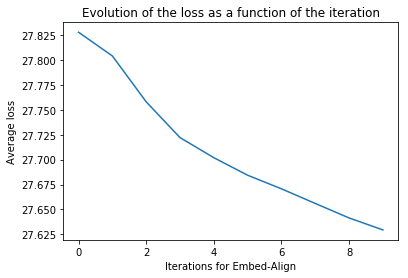

In [13]:
class EmbedAlign(nn.Module):
    def __init__(self, vocab_size_en,vocab_size_fr, embedding_dim):
        super(EmbedAlign, self).__init__()
        
        self.vocab_size_en = vocab_size_en
        self.vocab_size_fr = vocab_size_fr
        self.embedding_dim = embedding_dim
        #for the inference model
        self.w_embeddings = nn.Embedding(self.vocab_size_en, self.embedding_dim)
        #encoder        
        self.bidirLSTM = nn.LSTM(self.embedding_dim, self.embedding_dim, bidirectional=True)
        #h_i = hi< + hi>
        
        self.mu_1 = nn.Linear(self.embedding_dim, self.embedding_dim)
        self.mu_2 = nn.Linear(self.embedding_dim, self.embedding_dim)
            
        self.sigma_1 = nn.Linear(self.embedding_dim, self.embedding_dim)
        self.sigma_2 = nn.Linear(self.embedding_dim, self.embedding_dim)
        
        #for the generative model
        self.affine1L1 = nn.Linear(self.embedding_dim, self.embedding_dim)
        self.affine2L1 = nn.Linear(self.embedding_dim, self.vocab_size_en)
        
        self.affine1L2 = nn.Linear(self.embedding_dim, self.embedding_dim)
        self.affine2L2 = nn.Linear(self.embedding_dim, self.vocab_size_fr)
       
        self.dist_norm = torch.distributions.multivariate_normal.MultivariateNormal(torch.ones(self.embedding_dim),torch.diag(torch.ones(self.embedding_dim)))
            
    def forward(self, batch_en, batch_fr, mu_i, sigma_i, z_i, best_alignments):
        
        kl_score = 0.0
        sent_logx = 0.0
        sent_logy = 0.0
        
        m = len(batch_en)
        
        for x in range(len(batch_en)):
            
            word_x = batch_en[x]
            embeddings = self.w_embeddings(word_x)
            #view_shape = embeddings.shape[0]
            output, (hidden, cell) = self.bidirLSTM(embeddings.view(1, 1, -1)) 

            hid_f = hidden[0]
            hid_b = hidden[1]

            conc_hids = hid_f + hid_b
            
            mu = self.mu_1(conc_hids.squeeze())
            mu = F.relu(mu)
            mu = self.mu_2(mu)

            sigma = self.sigma_1(conc_hids.squeeze())
            sigma = F.relu(sigma)
            sigma = self.sigma_2(sigma)
            sigma = F.softplus(sigma)

            mu_i.append((word_x, mu))
            sigma_i.append((word_x,sigma))
            
            epsilon = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(self.embedding_dim),torch.diag(torch.ones(self.embedding_dim))).sample()

            #reparameterize
            zi = mu + epsilon * sigma
            z_i.append((word_x, zi))
            
            #generative using sampled zi
            #variational location and scale
            #same zi for x and y

            xi = self.affine1L1(zi)
            xi = F.relu(xi)
            xi = self.affine2L1(xi)
            xi = F.log_softmax(xi, dim=0) #cat generation - target

            yi = self.affine1L2(zi)
            yi = F.relu(yi)
            yi = self.affine2L2(yi)
            yi = F.log_softmax(yi, dim=0) #cat generation - source

            sent_logx += xi[word_x]
            
            kl_loss = -(1 + torch.log(sigma**2) - mu ** 2 - sigma**2)/2
            
            kl_score += kl_loss
            
            best_j = 0
            best_prob = 0
            for y in range(len(batch_fr)):
                word_y = batch_fr[y]
                y_prob = yi[word_y].data
                exp_y_prob = np.exp(y_prob)
                
                if exp_y_prob > best_prob:
                    best_prob = exp_y_prob
                    best_j = y 
                    best_y_prob = y_prob
                    
            best_alignments.append((x,best_j))
                    
            sent_logy += (-torch.Tensor([np.log(m)])) + best_y_prob
                
        final_out = -sent_logx - sent_logy + torch.sum(kl_score)
            
        return final_out, mu_i, sigma_i, xi,yi,z_i, best_alignments


epochs = 10
learning_rate = 0.01
model = EmbedAlign(vocabulary_size_en, vocabulary_size_fr, embedding_dim) #pad
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

losses = []
avg_losses = []

portion = 1000

print('epoch, total loss, average loss, duration')
for e in range(epochs):
    
    then = datetime.now()
    
    total_loss = 0.0
    for b in range(portion):

        mu_i = []
        sigma_i = []
        z_i = []
        best_alignments = []
        
        if len(batches_en[b]) > 0 and len(batches_fr[b]) > 0:
            batch_en = torch.tensor(np.asarray(batches_en[b]), dtype= torch.long)

            batch_fr = torch.tensor(np.asarray(batches_fr[b]), dtype= torch.long)

            optimizer.zero_grad()

            loss, mu_i, sigma_i, xi,yi,z_i, best_alignments = model(batch_en, batch_fr,mu_i, sigma_i, z_i, best_alignments)

            loss.backward()

            optimizer.step()

            total_loss += loss.item() 
    
    now = datetime.now()
        
    losses.append(total_loss)
    
    avg_loss = np.mean(losses)/len(batches_en)
    
    print(e, total_loss, avg_loss, now-then)
    
    avg_losses.append(avg_loss)
    
with open('mu_' + str(e) + '.pickle', 'wb') as file:
    pickle.dump(mu_i, file)
with open('sigma_' + str(e) + '.pickle', 'wb') as file:
    pickle.dump(sigma_i, file)
with open('xi_' + str(e) + '.pickle', 'wb') as file:
    pickle.dump(xi, file)
with open('yi_' + str(e) + '.pickle', 'wb') as file:
    pickle.dump(yi, file)

with open('model_embed' + str(portion) + '.pickle','wb') as file:
    pickle.dump(model,file)
      
iteration= list(range(len(avg_losses)))

plt.plot(iteration, avg_losses)
plt.xlabel("Iterations for Embed-Align")
plt.ylabel('Average loss')
plt.title('Evolution of the loss as a function of the iteration')
plt.savefig("embed" + str(portion)+".png")
plt.show()


In [61]:
len(model.w_embeddings.weight)

6330

In [54]:
mu_i

[(tensor(651), tensor(1.00000e-02 *
         [-0.0394, -0.1702,  0.1654, -0.1143, -0.0795, -0.1322, -0.3883,
          -0.3102,  0.3268,  1.6856, -0.7363, -0.1398,  0.3666,  0.5630,
          -0.5523, -0.4995,  0.4018,  1.1520, -0.1252,  0.3668,  0.1545,
           1.1566,  0.9851, -0.2536, -0.5391, -0.8794, -0.1441, -0.2989,
           0.4453, -0.6884,  0.1933, -0.7992, -0.4818,  0.3102,  0.2419,
           0.5429, -0.9620,  1.2906, -1.2601, -0.3279, -0.0656, -0.1035,
          -0.4948,  0.5398, -0.8085,  0.4382, -0.6078,  0.5787,  0.5502,
           0.9391, -0.3852, -0.2138, -1.1644,  0.1110,  0.0059,  0.1697,
           0.8674, -0.9582, -0.0120, -1.0850, -1.3202,  0.0765, -0.5263,
          -0.3033, -0.4428,  0.4801,  0.2740,  0.1823, -0.0122,  0.1252,
          -0.7744,  0.3290,  0.7766, -0.8069,  0.6963, -1.2154, -1.1400,
           0.2774,  0.0279, -0.5948, -0.7281, -0.6546,  1.1699,  0.8095,
          -0.3029, -0.0841,  0.8815, -0.0464, -0.6955,  0.6826, -0.5940,
          -0.29